# P2: Project Results (Sigma Squad)

## 1/ Analysis of the final merged data set:

In [26]:
from src.data.transform_data import raw_data, clean_data

raw_df = raw_data()
raw_df.to_csv('data/final_merged_data.csv', index=False)

After the loading, merging, and pre-processing of our 3 datasets, we obtained the final dataset (`final_merged_data.csv`) composed of:

|                           | Movie name           | Movie release date | Movie box office revenue | Movie runtime | Movie languages | Movie countries | Movie genres | Movie score | Movie votes | Movie director | Movie star | Movie budget | Movie gross | Movie company | Number of nominations | Nomination winner |
|---------------------------|----------------------|---------------------|--------------------------|---------------|-----------------|-----------------|--------------|-------------|-------------|-----------------|------------|--------------|-------------|---------------|-----------------------|-------------------|
| **Type of values**        | Str                  | Int                | Float                    | Int           | Str             | Str             | Str          | Float       | Int         | Str             | Str        | Float        | Float       | Str           | Int                   | Int               |
| **Example**               | midnight_in_paris	       | 2011              | 151119219.0               | 100.0           | French Language          | United States of America, Spain      | Romantic comedy, Romance Film        | 7.7         | 398000.0      | Woody Allen | Owen Wilson | 17000000.0   | 151653750.0	  | Mediapro	 | 1.0                     | Dianne Wiest	               |
| **Number of rows with info** |  81741               | 74839                 |  8401                       | 61291            | 81741              | 73587              | 79447          | 5605          | 5605          | 5605              | 5605        | 4148           | 5496          | 5596            | 1011                    | 297                |

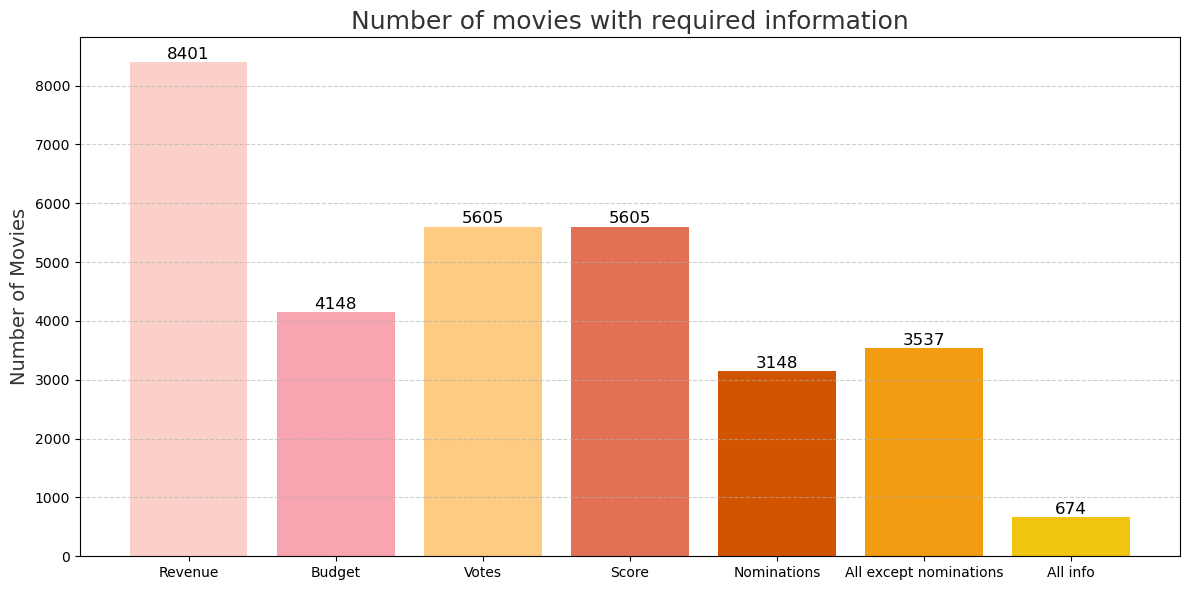

In [30]:
from src.utils.plot_graphs import bar_plot_available_data, hist_std_config
import src.utils.plot_graphs
import importlib

importlib.reload(src.utils.plot_graphs)

bar_plot_available_data(raw_df)

To establish the success of our index, we are focused on specific criteria such as budget, revenues, ratings, number of nominations, and the profitability. Our goal is to assess whether we have enough reliable data to effectively study these factors. We analyzed the available data and determined that the original CMU Movie dataset contains 8 401 movies, with revenue data as the minimum required for our project. From the additional dataset, we identified 5 119 movies that meet other key criteria, including budget, votes, and score, which represents about 64% of the original dataset. Given this sample size, we are confident that we have sufficient and reliable data to move forward with constructing the success index. The next step will be to normalize and properly weight each criterion to build the success index.

In [31]:
df = clean_data(raw_df)

## 2/ Movie success index:

To create our success index, we evaluated movie success based on four key factors: profitability, revenue, reviews, and Oscar nominations. Both profitability and revenue were scaled using min-max normalization, providing a consistent framework to evaluate and compare success across variables with different ranges. 

After calculating the factors, we combined them into a final index. Profitability, revenue, and review factors are weighted (35%, 35%, and 30%, respectively) and adjusted by the Oscar factor. The resulting index is normalized again to a 0-10 scale, offering a single score representing each movie’s overall success.

Here is a more detailed explanation of the setup of each factor. Note that all functions used can be found in the `src/movie_success_model.py` file.

- **Profitability factor:** this factor measures how much revenue a movie generates relative to its budget. First, the profitability ratio (revenue divided by budget) is calculated. To reduce the impact of outliers, a logarithmic transformation (log) is applied, which compresses large values and accentuates smaller ones. The result is normalized to a 0-10 scale, making comparisons across movies straightforward.

- **Revenue factor:** this factor focuses solely on the movie's box office revenue. A log10 transformation is applied to balance the range of high and low revenues, particularly since box office numbers can vary greatly. After applying the transformation, scores are scaled from 0 to 10 for consistency.

- **Oscar multiplication factor:** this factor amplifies the success index based on Oscar nominations, recognizing industry recognition as a mark of success. The function uses a logarithmic transformation for diminishing returns, giving a smaller increase for each additional nomination, then scales by a multiplier to ensure consistent weighting.

Below are histograms for each factor, showing the final distribution after applying our adjustments.

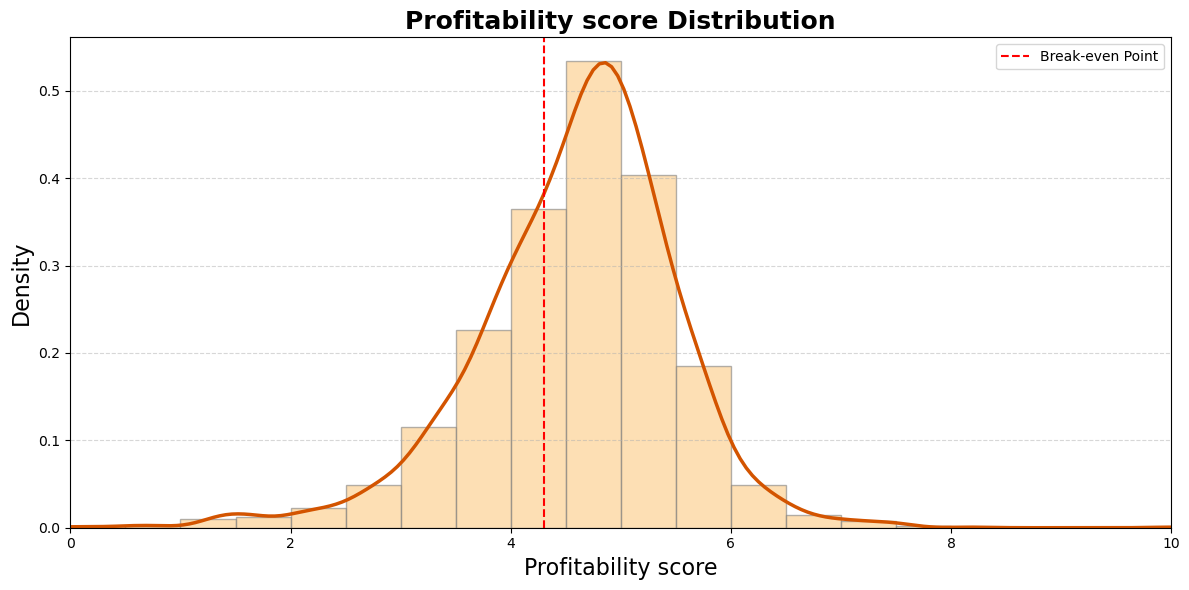

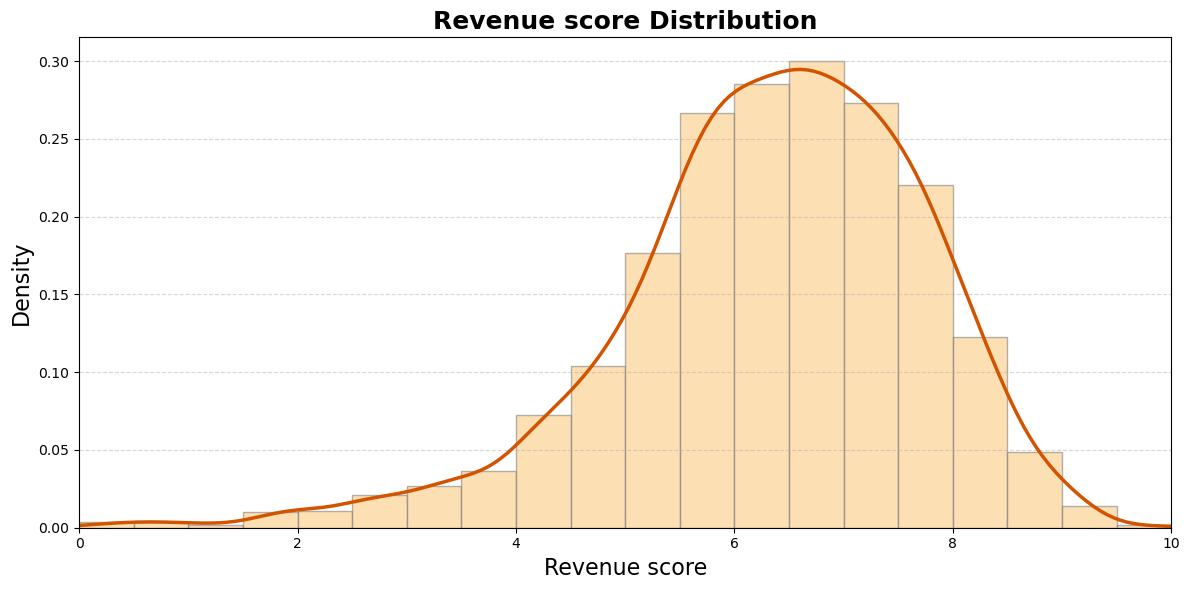

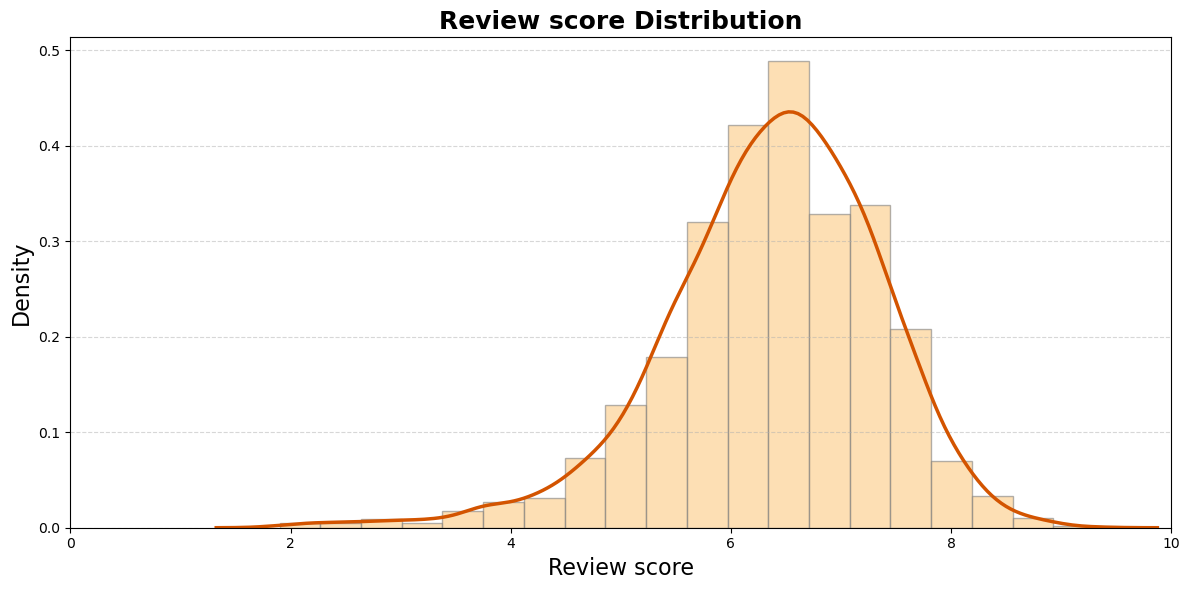

In [32]:
from src.models.movie_success_model import movie_success_index

movie_success_index(df)

hist_std_config(df, 'Profitability score')
hist_std_config(df, 'Revenue score')
hist_std_config(df, 'Review score')


## 3/ Actor Success Index: